In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from time import time

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Download files, set up folder, put files into folder

In [2]:
# training data: ./train.tsv
# test data:     ./test.tsv

In [3]:
filepath = './train.tsv'
dataframe = pd.read_csv(filepath, sep = '\t')
print('training data size:', len(dataframe))
print(dataframe)

training data size: 29996
       label                                             review
0          0  Leaks: Liss seems to be totally incompetent: m...
1          1  Replacement Peeler: Loved my old one. Loaned i...
2          0  Not what I was expecting: I chose to rate this...
3          1  Watch face is hard to read: Although I don't o...
4          0  Disappointing: I was eager to read this book s...
...      ...                                                ...
29991      1  Love EW: I must admit that I am a total TV afi...
29992      1  Easy to follow and delicious recipes!: I compl...
29993      1  The Beauty and Mystery of Veronique: Perhaps t...
29994      1  I love it.: Brilliant, hilarious, quick and ea...
29995      0  broken...: bad choice...2d film would not play...

[29996 rows x 2 columns]


# Count unigrams

In [4]:
# keep a counter of word frequency
counter = Counter()
for index, row in dataframe.iterrows():
    counter.update(row['review'].strip().lower().split())
print('Number of unique words:', len(counter))

# sort words by frequency from high to low
for word, count in sorted(counter.items(), key = lambda x: x[1], reverse = True)[:20]:
    print (word, count)

Number of unique words: 153396
the 117015
and 63290
a 60040
i 59790
to 57239
of 47056
this 41925
is 40356
it 39287
in 27000
for 25540
that 22153
was 19841
not 18893
you 17548
with 16919
but 16569
on 15657
have 15061
my 15027


# Document length distribution

In [5]:
# keep a list of document lengths (document length = # of tokens in review)
length_array = []
for index, row in dataframe.iterrows():
    length_array.append( len(row['review'].strip().lower().split()) )
print ('document length average:', np.mean(length_array))
print ('document length standard deviation:', np.std(length_array))

document length average: 78.49409921322842
document length standard deviation: 42.82795227790141


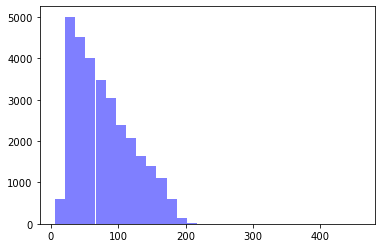

In [6]:
num_bins = 30
n, bins, patches = plt.hist(length_array, num_bins, facecolor='blue', alpha=0.5)
plt.show()

# Topic modeling

In [7]:
# We extract topics (principle components) from the document-word matrix of the training corpus
# Note that instead of directly using principal component analysis (PCA), we use another matrix 
# decomposition method called latent Dirichlet allocation (LDA), which has the nice property
# that all principal components (topics) are probability distributions over words (words have
# nonnegative coefficients in a topic), as opposed to the less intutive linear combinations of 
# words (where words in a topic may be assigned negative coefficients).

# adapted from: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html

In [8]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [9]:
# Extracting the document-word matrix from the corpus

# Useful topical words should not appear in all documents 
# For example, a word should not appear in more than 95% of all documents
MAX_DOCUMENT_FREQUENCY = 0.95

# Useful topical words should not appear in too few documents
# For example, a word should appear in at least two documents
MIN_DOCUMENT_FREQUENCY = 2

# Although we have more than 150K unique words in the corpus,
# In topic analysis we only need to use a subset of them
MAX_NUMBER_OF_WORDS = 10000

tf_vectorizer = CountVectorizer(
    max_df = MAX_DOCUMENT_FREQUENCY, 
    min_df = MIN_DOCUMENT_FREQUENCY,
    max_features = MAX_NUMBER_OF_WORDS,
    stop_words="english"
)

tf_matrix = tf_vectorizer.fit_transform(dataframe['review'])

done in 16.683s.


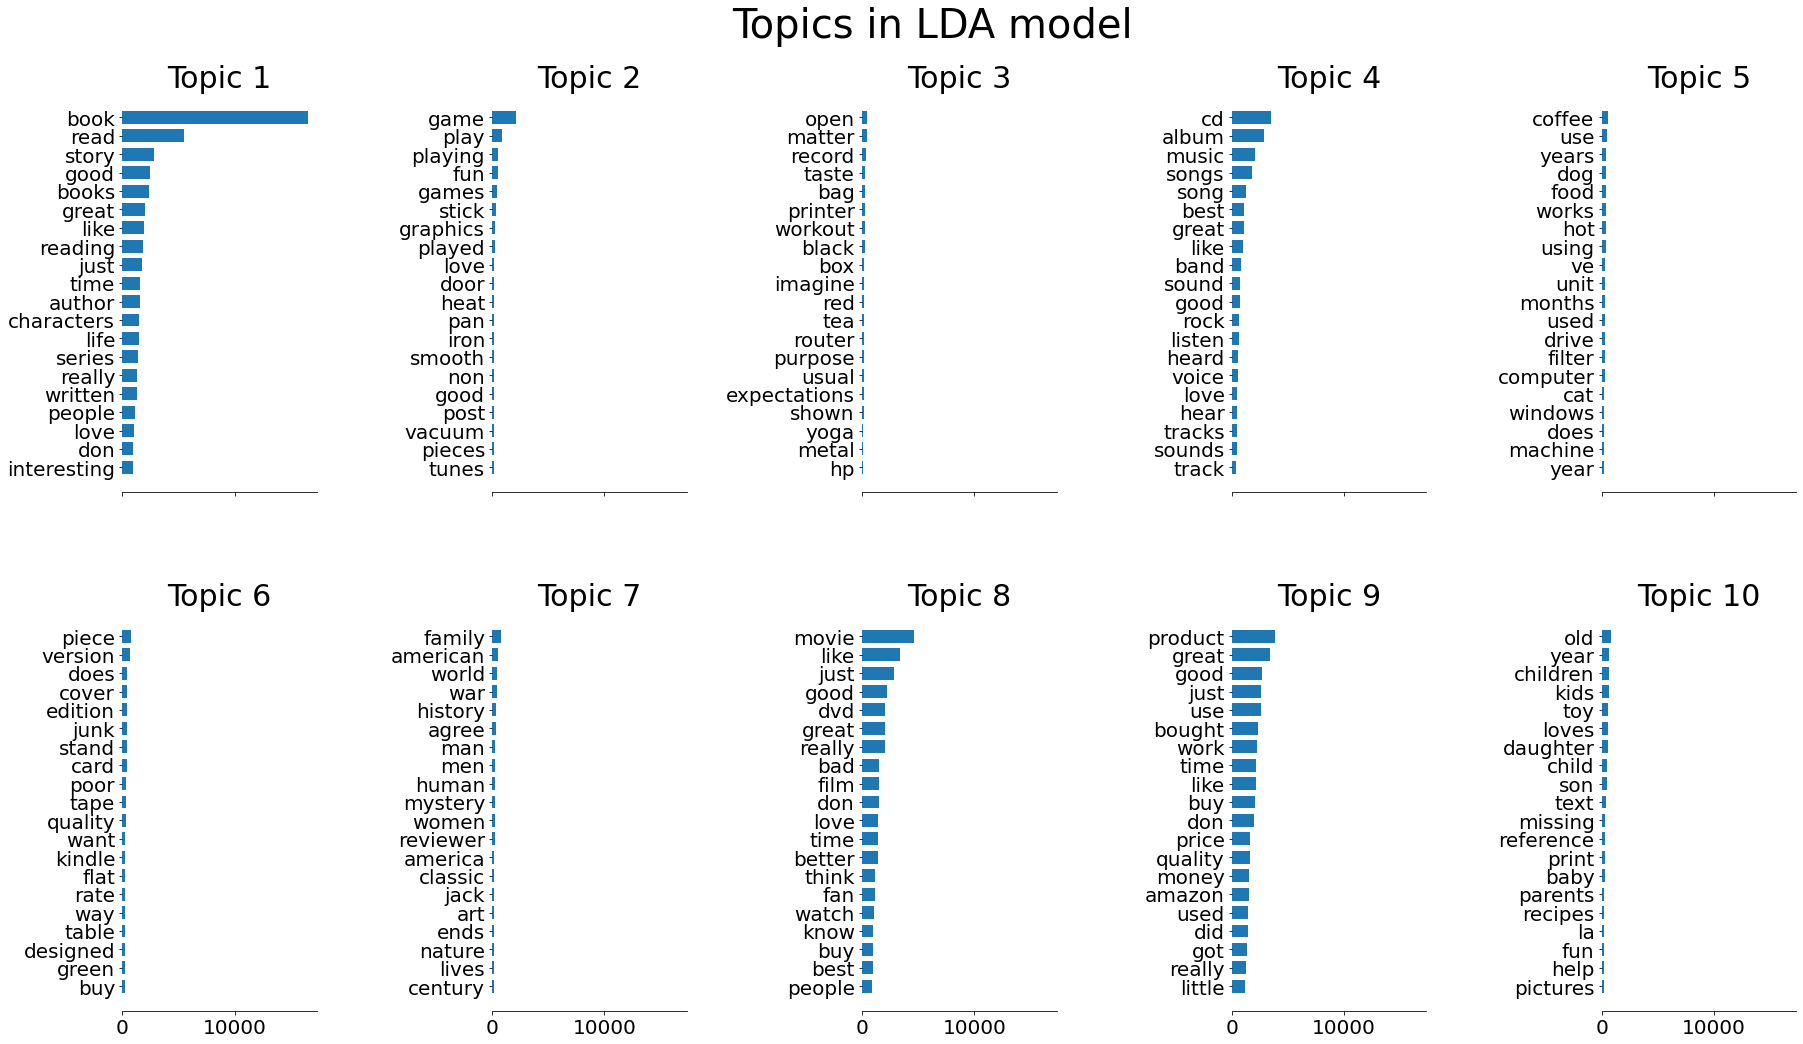

In [10]:
# Only show n_top_words that have the largest loading from each topic
NUM_TOP_WORDS = 20
# Only extract 10 topics (i.e., principal components)
NUM_TOPICS = 10

# Instantiate the Latent Dirichlet Allocation model
lda = LatentDirichletAllocation(
    n_components = NUM_TOPICS,
    max_iter = 5,
    learning_method = "online",
    learning_offset = 50.0,
    random_state = 0,
)

# Fit the LDA model
t0 = time()
lda.fit(tf_matrix)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, NUM_TOP_WORDS, "Topics in LDA model")

# Label Distribution 

In [11]:
# keep a list of title lengths (title length = # of tokens in title)
counter = Counter()
for index, row in dataframe.iterrows():
    counter.update(str(row['label']))
print(counter)

Counter({'1': 15091, '0': 14905})


In [12]:
print('Positive label', counter['1']/sum(counter.values()))
print('Negative label', counter['0']/sum(counter.values()))

Positive label 0.5031004133884518
Negative label 0.4968995866115482
